In [1]:
import numpy as np
import os
import pickle
import torch
from fitting.utils import get_output_dirs, get_best_model_version, get_data_generator_inputs
from behavenet.models import AE
from data.data_generator import ConcatSessionsGenerator

## Load data

In [2]:
include_linear = True
data_dir = '/home/mattw/data'  # might be a different path than what is saved in hparams
hparams_og = {
    'tt_save_path': '/home/mattw/results/behavenet',
    'lab': 'steinmetz',
    'expt': '2-probe',
    'animal': 'mouse-01',
    'session': 'session-01',
    'n_ae_latents': 12,
    'experiment_name': 'test',
#     'lab': 'musall',
#     'expt': 'vistrained',
#     'animal': 'mSM30',
#     'session': '10-Oct-2017',
#     'n_ae_latents': 16,
#     'experiment_name': 'initial_grid_search',
    'model_class': 'ae',
    'model_type': 'conv',  # 'conv' | 'linear'
}

# get best model version
_, _, expt_dir = get_output_dirs(hparams_og)
model_version = get_best_model_version(expt_dir)[0]
version_dir = os.path.join(expt_dir, model_version)
arch_file = os.path.join(version_dir, 'meta_tags.pkl')
model_file = os.path.join(version_dir, 'best_val_model.pt')
with open(arch_file, 'rb') as f:
    hparams = pickle.load(f)
    hparams['data_dir'] = data_dir

# build data generator
hparams, signals, transforms, load_kwargs = get_data_generator_inputs(hparams)
ids = {
    'lab': hparams['lab'],
    'expt': hparams['expt'],
    'animal': hparams['animal'],
    'session': hparams['session']}
data_generator = ConcatSessionsGenerator(
    hparams['data_dir'], ids, 
    signals=signals, transforms=transforms, load_kwargs=load_kwargs,
    device=hparams['device'], as_numpy=hparams['as_numpy'],
    batch_load=hparams['batch_load'], rng_seed=hparams['rng_seed'])

# build models
model_cae = AE(hparams)
model_cae.load_state_dict(torch.load(model_file))
model_cae.to(hparams['device'])
model_cae.eval()

if include_linear:
    import copy
    
    hparams_lin = copy.copy(hparams_og)
    hparams_lin['model_type'] = 'linear'
    
    # get best model version
    _, _, expt_dir = get_output_dirs(hparams_lin)
    model_version = get_best_model_version(expt_dir)[0]
    version_dir = os.path.join(expt_dir, model_version)
    arch_file = os.path.join(version_dir, 'meta_tags.pkl')
    model_file = os.path.join(version_dir, 'best_val_model.pt')
    with open(arch_file, 'rb') as f:
        hparams_lin = pickle.load(f)
        hparams_lin['data_dir'] = data_dir

    model_lin = AE(hparams_lin)
    model_lin.load_state_dict(torch.load(model_file))
    model_lin.to(hparams['device'])
    model_lin.eval()

## Push images through the decoder

In [11]:
batch['batch_indx']

tensor([92])

In [10]:
batch, dataset = data_generator.next_batch('test')
ims_orig = batch['images'][0, :200]

# process batch
ims_recon_cae, _ = model_cae(ims_orig)
ims_orig_in = ims_orig.cpu().detach().numpy()
ims_recon_cae_in = ims_recon_cae.cpu().detach().numpy()

if include_linear:
    # process batch
    ims_recon_lin, _ = model_lin(ims_orig)
    ims_recon_lin_in = ims_recon_lin.cpu().detach().numpy()
else:
    ims_recon_lin_in = None

In [12]:
# rotate first channel of musall data
if hparams['lab'] == 'musall':
    def rotate(img_stack):
        if img_stack is not None:
            tmp = np.concatenate([
                np.flip(np.swapaxes(img_stack[:, 0, :, :], -1, -2), axis=-1)[:, None, :, :],
                img_stack[:, 1, None, :, :]],
                axis=1)
        else:
            tmp = None
        return tmp
    ims_orig_in = rotate(ims_orig_in)
    ims_recon_cae_in = rotate(ims_recon_cae_in)
    ims_recon_lin_in = rotate(ims_recon_lin_in)

In [16]:
test = np.mean(ims_orig_in-ims_recon_lin_in)**2
print(test * (192 * 112))

0.000291055131137341


In [13]:
print('CAE MSE: {}'.format(np.mean(ims_orig_in-ims_recon_cae_in)**2))
print('Lin MSE: {}'.format(np.mean(ims_orig_in-ims_recon_lin_in)**2))

CAE MSE: 0.0006264744257523415
Lin MSE: 1.3534929833395693e-08


In [36]:
print('CAE MSE: {}'.format(np.mean(ims_orig_in-ims_recon_cae_in)**2))
print('Lin MSE: {}'.format(np.mean(ims_orig_in-ims_recon_lin_in)**2))

CAE MSE: 7.3218557411622504e-06
Lin MSE: 3.1270449093743547e-06


In [26]:
def make_ae_reconstruction_movie(
    ims_orig, ims_recon_cae, ims_recon_lin=None, save_file=None, n_ae_latents=None):

    import matplotlib.pyplot as plt
    # plt.rcParams['animation.ffmpeg_path'] = '/anaconda3/envs/tensorflow/bin/ffmpeg' # super important line. should appear before matplotlib
    import matplotlib.animation as animation
    from matplotlib.gridspec import GridSpec
    from matplotlib.animation import FFMpegWriter

    n_channels = ims_orig.shape[1]
    n_cols = 2
    n_rows = 1 if ims_recon_lin is None else 3
    offset = 1.5 if n_channels == 1 else 5
    fig = plt.figure(figsize=(5 * n_cols, n_rows + offset))
    if n_ae_latents is not None:
        title = str('Behavorial video compression\n%i dimensions' % n_ae_latents)
    else:
        title = 'Behavorial video compression'
    fig.suptitle(title, fontsize=20)
        
    gs = GridSpec(n_rows, n_cols, figure=fig)
    axs = []
    if ims_recon_lin is None:
        axs.append(fig.add_subplot(gs[0, 0])) # 0: original frames
        axs.append(fig.add_subplot(gs[0, 1])) # 1: cae reconstructed frames
        axs.append(fig.add_subplot(gs[0, 2])) # 2: cae residuals
    else:
        axs.append(fig.add_subplot(gs[0, 0])) # 0: original frames
        axs.append(fig.add_subplot(gs[1, 0])) # 1: cae reconstructed frames
        axs.append(fig.add_subplot(gs[1, 1])) # 2: cae residuals
        axs.append(fig.add_subplot(gs[2, 0])) # 3: linear reconstructed frames
        axs.append(fig.add_subplot(gs[2, 1])) # 4: linear residuals
    for ax in fig.axes:
        ax.set_xticks([])
        ax.set_yticks([])

    fontsize = 16
    axs[0].set_title('Original', fontsize=fontsize)
    axs[1].set_title('Conv reconstructed', fontsize=fontsize)
    axs[2].set_title('Conv residual', fontsize=fontsize)
    if ims_recon_lin is not None:
        axs[3].set_title('Linear reconstructed', fontsize=fontsize)
        axs[4].set_title('Linear residual', fontsize=fontsize)
        
    ims_res_cae = ims_orig - ims_recon_cae
    if ims_recon_lin is not None:
        ims_res_lin = ims_orig - ims_recon_lin

    def concat(ims_3channel):
        return np.concatenate(
            [ims_3channel[0, :, :], ims_3channel[1, :, :]], axis=1)
    
    default_kwargs = {
        'animated': True,
        'cmap': 'gray',
        'vmin': 0,
        'vmax': 1}
    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    ims = []
    for i in range(ims_orig.shape[0]):

        ims_curr = []

        # original video
        if n_channels == 1:
            ims_orig_tmp = ims_orig[i, 0]
        else:
            ims_orig_tmp = concat(ims_orig[i])
        im = axs[0].imshow(ims_orig_tmp, **default_kwargs)
        ims_curr.append(im)
        # cae reconstructed video
        if n_channels == 1:
            ims_recon_cae_tmp = ims_recon_cae[i, 0]
        else:
            ims_recon_cae_tmp = concat(ims_recon_cae[i])
        im = axs[1].imshow(ims_recon_cae_tmp, **default_kwargs)
        ims_curr.append(im)
        # cae residual video
        if n_channels == 1:
            ims_res_cae_tmp = ims_res_cae[i, 0]
        else:
            ims_res_cae_tmp = concat(ims_res_cae[i])
        im = axs[2].imshow(0.5 + ims_res_cae_tmp, **default_kwargs)
        ims_curr.append(im)
        if ims_recon_lin is not None:
            # linear reconstructed video
            if n_channels == 1:
                ims_recon_lin_tmp = ims_recon_lin[i, 0]
            else:
                ims_recon_lin_tmp = concat(ims_recon_lin[i])
            im = axs[3].imshow(ims_recon_lin_tmp, **default_kwargs)
            ims_curr.append(im)
            # linear residual video
            if n_channels == 1:
                ims_res_lin_tmp = ims_res_lin[i, 0]
            else:
                ims_res_lin_tmp = concat(ims_res_lin[i])
            im = axs[4].imshow(0.5 + ims_res_lin_tmp, **default_kwargs)
            ims_curr.append(im)
            
        ims.append(ims_curr)

    ani = animation.ArtistAnimation(fig, ims, blit=True, repeat_delay=1000)
    metadata = {'title': 'ae reconstruction'}
    writer = FFMpegWriter(fps=15, metadata=metadata, bitrate=-1)

    if save_file is not None:
        if not os.path.isdir(os.path.dirname(save_file)):
            os.makedirs(os.path.dirname(save_file))
        if save_file[-3:] != 'mp4':
            save_file += '.mp4'
        ani.save(save_file, writer=writer)
        print('video saved to %s' % save_file)


video saved to /home/mattw/results/temp/testing_linear.mp4


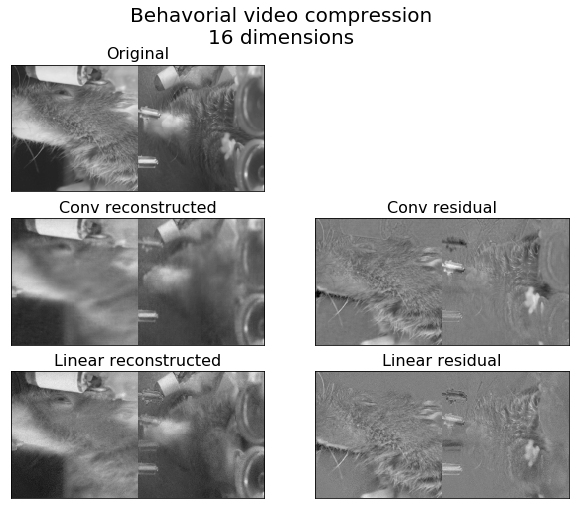

In [27]:
save_file = str('/home/mattw/results/temp/%s_testing' % hparams['lab'])
if include_linear:
    save_file += '_linear'
    
make_ae_reconstruction_movie(
    ims_orig=ims_orig_in,
    ims_recon_cae=ims_recon_cae_in,
    ims_recon_lin=ims_recon_lin_in,
    save_file=save_file, n_ae_latents=hparams['n_ae_latents'])